In [340]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from kmodes import kmodes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
from sklearn.decomposition import PCA
import random
from scipy.spatial.distance import cdist,pdist
moviesdf1 = pd.read_csv('./ml-latest-small/movies.csv')

ratingsdf = pd.read_csv('./ml-latest-small//ratings.csv')
ratingsdf=ratingsdf.groupby('movieId').filter(lambda x: len(x) >= 10)
ratingsdf=ratingsdf.reset_index(drop=True)

In [341]:
cols_to_be_repeated = ["movieId", "title"]
splitdf = lambda x: x.split('|')
s = moviesdf1.genres.str.split("|").apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
del moviesdf1['genres']
moviesdfnew=moviesdf1.join(pd.DataFrame(s))



In [342]:
moviesdfnew.columns = ['movieId','title','genres']


In [343]:
df=pd.get_dummies(moviesdfnew['genres'])

In [344]:
moviesdf2=df.groupby(df.index).sum()
movies=moviesdf1.join(moviesdf2, lsuffix='_moviesdf1', rsuffix='_moviedsf2')

In [345]:

titles = movies
titles1 = titles.drop(titles.columns[[0, 1]], axis=1, inplace=True)
titles1 = titles.as_matrix()
random.seed(3)

In [346]:
def withinss(km): 
    centroids =(km.cluster_centroids_)
    D_k = [cdist(titles, centroids, 'jaccard')]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/titles.shape[0] for d in dist]
    return avgWithinSS




In [347]:
def clusterFilms(titles):
    random.seed(101)
    i = 1
    while(1):
        i = i+1
        movieCluster1 = kmodes.KModes(n_clusters=i, init='Huang', n_init=3, verbose=1).fit(titles)
        movieCluster2 = kmodes.KModes(n_clusters=i+1, init='Huang', n_init=3, verbose=1).fit(titles)
        ss1 = withinss(movieCluster1)
        ss2 = withinss(movieCluster2)
        #print ss1
         #decision criterion
        dss = (ss1[0]-ss2[0])/ss1[0]
        #exit if dss < 0.2
        if (dss < 0.2):
            pca = PCA(n_components=2).fit(titles)
            pca_2d = pca.transform(titles)
            plotgraphs(pca_2d,movieCluster1,titles,i,pca)
            #for j in range(0, pca_2d.shape[0]):
                #if movieCluster1.labels_[j] == 0:
                #c1 = plt.scatter(pca_2d[j,0],pca_2d[j,1],c= movieCluster1.labels_[j],marker=movieCluster1.labels_[j])
                #if movieCluster1.labels_[j]==1:
                      #c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='b',
                     #marker='*')
                #if movieCluster1.labels_[j]==2:
                      #c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='g',
                     #marker='o')
            #plt.show()
            print("no of cluster ",i)
            break
    return(movieCluster1)
        

In [348]:
def plotgraphs(pca_2d,movieCluster1,titles,i,pca):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_2d) + (i + 1) * 10])
    silhouette_avg = silhouette_score(titles, movieCluster1.labels_)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(titles, movieCluster1.labels_)
    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[movieCluster1.labels_ == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(j) / i)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(movieCluster1.labels_.astype(float) / i)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
     # Labeling the clusters
    centers = pca.transform(movieCluster1.cluster_centroids_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % k, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')

    plt.show()



In [349]:
#moviecluster=clusterFilms(titles)

#ratingsdf.head()
def getUserInfo(ratingsdf,id):
    df = ratingsdf[ratingsdf.userId == 3][['movieId','rating']]
    a=pd.DataFrame(df.sort('movieId'))
    a=a.reset_index(drop=True)    
    return a


In [350]:
def setcluster(moviecluster,a):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df2 = df1[df1.movieId.isin(a.movieId)]
    df2=df2.reset_index(drop=True)
    a['cluster']=df2.clusterno

    return a

In [351]:
def getmeanratings(a):
    b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    
    c = b[b.rating==max(b.rating)].index
    return c


In [352]:
def getrecommendedfilms(c,moviecluster,moviesdf1,a,ratingsdf):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df3=df1[df1.clusterno.isin(c)][['movieId']]
    df3 = df3.reset_index(drop=True)
    df3 = df3[~df3.movieId.isin(a.movieId)]
    df3 = df3.reset_index(drop=True)
    d = ratingsdf[ratingsdf.movieId.isin(df3.movieId)]
#b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    d = d.reset_index(drop=True)
    r=pd.DataFrame(d.groupby(d.movieId)['rating'].mean())
    t=moviesdf1[moviesdf1.movieId.isin(r.index)]['title']
    t.index = r.index
    r['title']=t
    return r.sort_values(by='rating',ascending=False)


In [353]:
def recommend(titles,moviesdf1,ratingsdf,userid,number):
    moviecluster = clusterFilms(titles)
    print ("The silhouette score is %f" % (silhouette_score(titles,moviecluster.labels_)))
    print (" The Average within sum of square distance is %f" % (withinss(moviecluster))[0])
    activeuser = getUserInfo(ratingsdf,userid)
    activeuser = setcluster(moviecluster,activeuser)
    cluster = getmeanratings(activeuser)
    recommend = getrecommendedfilms(cluster,moviecluster,moviesdf1,activeuser,ratingsdf)
    top = recommend.head(n = 50)
    
    return top.sample(number)
    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 170, cost: 18611.0
Run 1, iteration: 2/100, moves: 0, cost: 18611.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 474, cost: 18492.0
Run 2, iteration: 2/100, moves: 0, cost: 18492.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 161, cost: 15975.0
Run 3, iteration: 2/100, moves: 0, cost: 15975.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 635, cost: 15595.0
Run 1, iteration: 2/100, moves: 546, cost: 15013.0
Run 1, iteration: 3/100, moves: 720, cost: 14177.0
Run 1, iteration: 4/100, moves: 288, cost: 14177.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 999, cost: 13609.0
Run 2, iteration: 2/100

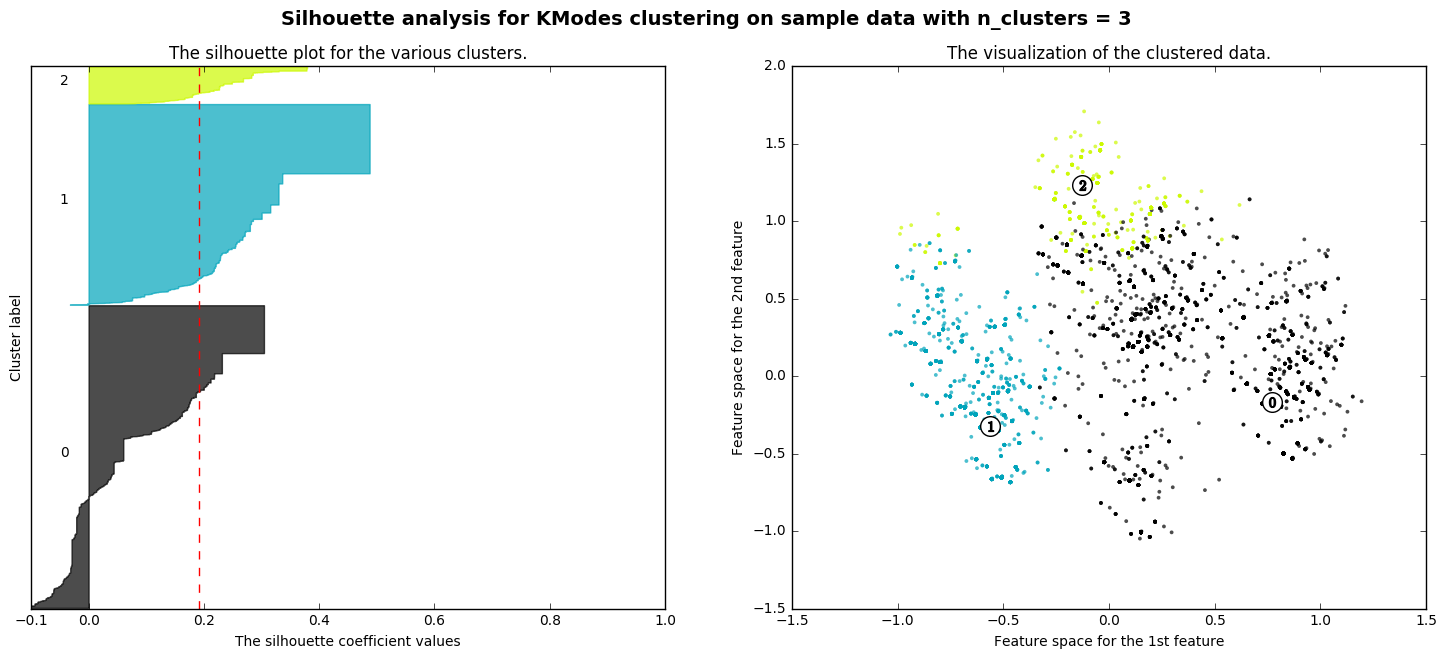

no of cluster  3
The silhouette score is 0.192008
 The Average within sum of square distance is 0.512419


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
954,4.225806,Mr. Smith Goes to Washington (1939)
3469,4.541667,Inherit the Wind (1960)
1209,4.218750,Once Upon a Time in the West (C'era una volta ...
2186,4.260870,Strangers on a Train (1951)
926,4.434211,All About Eve (1950)
1305,4.291667,"Paris, Texas (1984)"
1193,4.256944,One Flew Over the Cuckoo's Nest (1975)
922,4.294872,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
6016,4.297101,City of God (Cidade de Deus) (2002)


In [354]:
recommend(titles,moviesdf1,ratingsdf,3,10)
